In [1]:
import torch
from torch.distributions import Normal, Bernoulli
from utils.losses.elbo_logistic_reg import elbo
from utils.fit import MeanFieldParams, FullRankParams, train_advi
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, average_precision_score

# Set default type to float64 (instead of float32)
torch.set_default_dtype(torch.float64)

In [2]:
from sklearn.datasets import load_breast_cancer
cancer1 = load_breast_cancer()

x = cancer1.data[:,:10]
y = cancer1.target

x = torch.from_numpy(x)
y = torch.from_numpy(y).to(torch.float64)
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=123)

In [3]:
advi_mode = "fullrank"
advi_mode = "meanfield"

if advi_mode == "fullrank":
    model_params = {'params': FullRankParams(size=10)}
elif advi_mode == "meanfield":
    model_params = {'beta': MeanFieldParams(size=10)}

elbo_hist = []
logpred_hist = []

In [10]:
elbo_hist, logpred_hist = train_advi(
    x_train, y_train, x_val, y_val, 
    model_params, elbo,
    full_data_size=x_train.shape[0],
    max_iter=10000,
    batch_size=100,
    lr=0.001,
    advi_mode=advi_mode,
    elbo_hist=elbo_hist,
    logpred_hist=logpred_hist,
)

We plot the elbo history, which seems to indicate convergence.

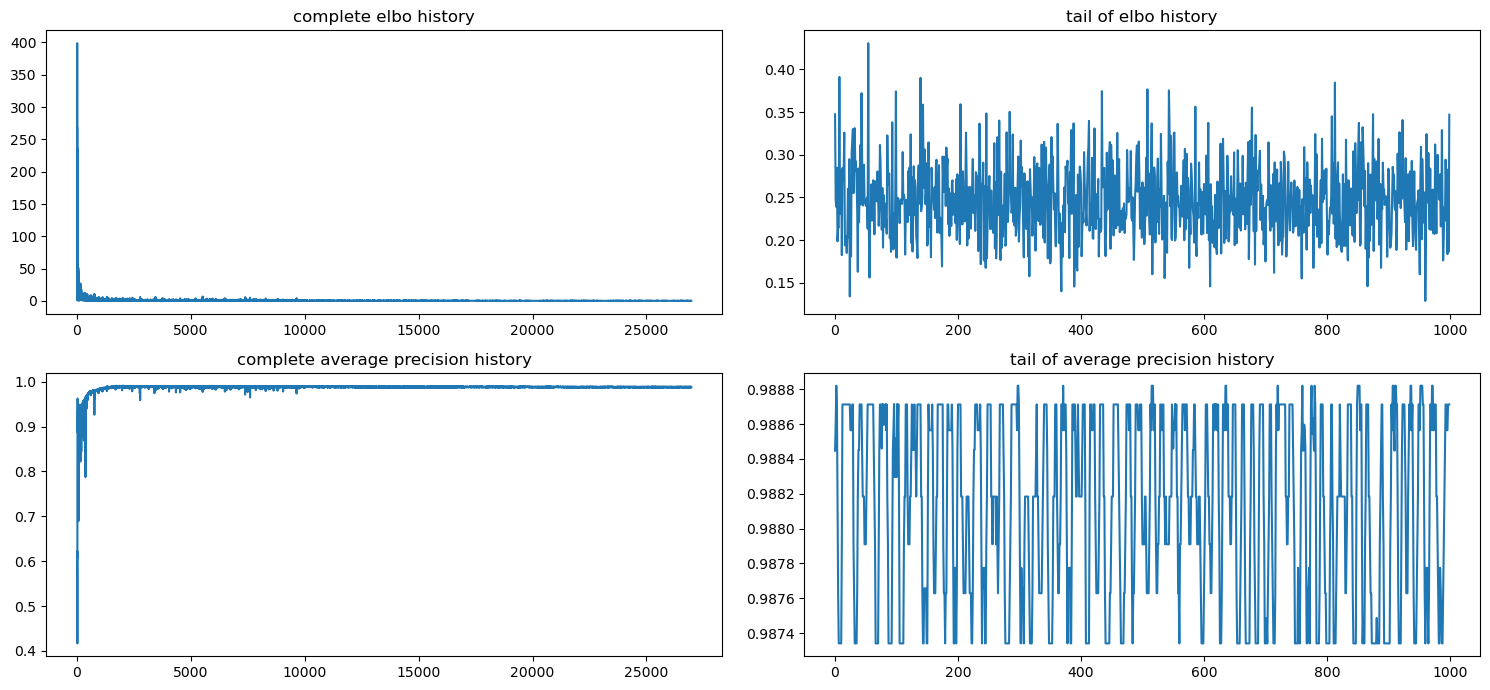

In [11]:
# Plot ELBO history
fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(15, 7))

axes[0, 0].plot(elbo_hist)
axes[0, 0].set_title('complete elbo history')

# Plot ELBO history (after 100-th iteration)
axes[0, 1].plot(elbo_hist[-1000:])
axes[0, 1].set_title('tail of elbo history')

# Plot ELBO history
axes[1, 0].plot(logpred_hist)
axes[1, 0].set_title('complete average precision history')

# Plot ELBO history (after 100-th iteration)
axes[1, 1].plot(logpred_hist[-1000:])
axes[1, 1].set_title('tail of average precision history')
plt.show()

We inspect the statistics of the posterior in this cell.
The posterior mean and SD are printed. They are consistent with the true values.


In [6]:
if advi_mode == "meanfield":
    betas = model_params["beta"].mean.detach().numpy()
elif advi_mode == "fullrank":
    betas = model_params["params"].mean.detach().numpy()

y_pred = torch.sigmoid(x_val@betas)
accuracy_score(y_val, y_pred>0.5)

0.9440559440559441

In [7]:
if advi_mode == "fullrank":
    beta_mean = model_params['params'].mean.detach().numpy()
    print('param mean: {}'.format(beta_mean))
    beta_std = model_params['params'].L.detach().numpy()
    beta_std = beta_std
    beta_std = np.array_str(beta_std@beta_std.T, precision=4, suppress_small=True)
    print('param sd: \n{}'.format(beta_std))
elif advi_mode == "meanfield":
    beta_mean = model_params['beta'].mean.detach().numpy()
    print('beta mean: {}'.format(beta_mean))
    beta_std = model_params['beta'].log_s.exp().detach().numpy()
    beta_std = np.array_str(beta_std, precision=4, suppress_small=True)
    print('beta sd: {}'.format(beta_std))


beta mean: [  4.90676945  -0.3704974   -0.13963489  -0.06568672  -8.16616797
 -16.24498526 -17.06942435 -12.24078493 -10.74867891  -1.39276883]
beta sd: [0.002  0.0003 0.0005 0.0001 0.2547 0.0252 0.2247 0.0086 0.0321 0.0071]
